# Integrating lung datasets using EmbedMNN model

In this example, we will use *transmorph* to integrate lung datasets from three patients, gathered in [1]. These datasets contain in total more than 60k cells, which are all associated with a compartment annotation: *immune*, *stromal*, *endothelial* and *epithelial*. As cells show high transcriptomic differences between these compartments, we consider the integration of these datasets to be an "easy" task, compared to cases with many more, and more subtle cell types. We are interested in identifying subclusters in these compartments to identify cell subtypes.

We use one of our built-in models, **EmbedMNN**, to carry out the integration. It combines a few preprocessing steps (common genes space embedding, normalization and dimensionality reduction) with a mutual nearest neighbors (MNN)-based matching [2] and a low-dimensional space embedding using UMAP [3] or MDE [4]. This low dimensional space can subsequently be used to carry out tasks such as clustering.

### Loading the data bank

*transmorph* provides a few data banks for testing purposes, already preprocessed (cell/gene filtering, normalization, log1p...) and annotated. They can be loaded using *datasets* module. Lung databank contains three datasets in the AnnData format, each expressed in its 10,000 most variable genes space. Cells are annotated by the .obs key "class". If the queried databank is missing, it will be automatically downloaded, and saved locally for faster subsequent access.

In [1]:
from transmorph.datasets import load_travaglini_10x

# Format: {patient_label -> AnnData}
trav_10x = load_travaglini_10x()

# We convert it to List[AnnData] as we do not 
# care about label here
datasets = list(trav_10x.values())

databank_api > Loading bank travaglini_10x.


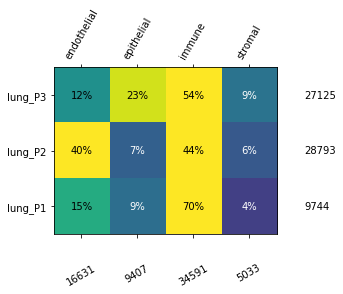

In [2]:
from transmorph.utils.plotting import plot_label_distribution_heatmap
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (1, 1)}):
    plot_label_distribution_heatmap(datasets, "class", trav_10x.keys())

### Plotting initial datasets using scatter_plot

The scatter_plot method can be used to display a low dimensional representation of a set of datasets. It will automatically use a *transmorph* integrated representation if present in all AnnData objects. If this integrated representation is missing, it will try to compute a UMAP of .X matrices. Computing this UMAP representation can take some time for large datasets, but it can then be cached to avoid recomputing every time.

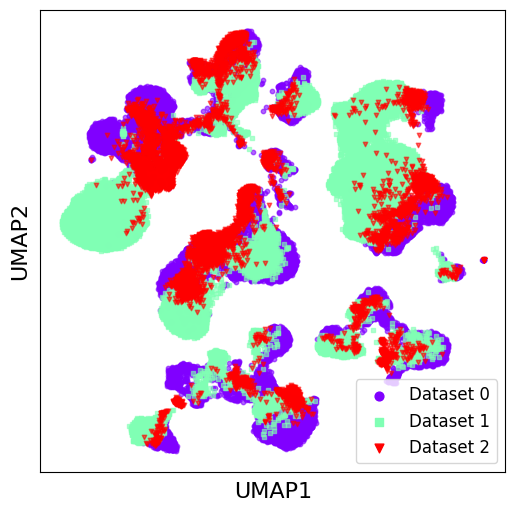

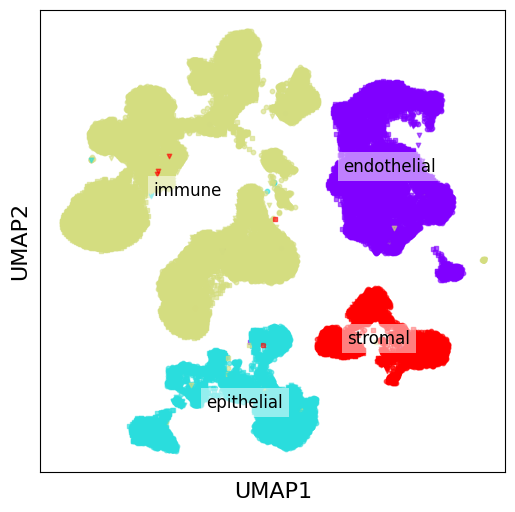

In [3]:
from transmorph.utils import plotting as tpl

tpl.reduce_dimension(datasets, reducer="umap", output_obsm="before_transmorph")

# use_cache=True allows to avoid recomputing a UMAP representation for each plot
tpl.scatter_plot(datasets, input_obsm="before_transmorph")
tpl.scatter_plot(
    datasets, 
    input_obsm="before_transmorph", 
    color_by="class", 
    plot_cluster_names=True, 
    show_legend=False
)

We can see here why we claim this is an "easy" databank to integrate. Differences between compartments are so important that compartments are already clustered in initial gene space. Though, we observe clear patient-dependent subclusters in these compartment clusters, which can cause issue when trying to identify biologically-relevant subpopulations.

### Dataset integration using MNNCorrection

**EmbedMNN** combines a mutual nearest neighbors step and a low-dimensional embedding, here using UMAP. Parameters can be tuned during model instanciation. Model can then be ran using transform() method, providing a list of AnnData objects. It will add a .obsm["transmorph"] entry, corresponding to the integrated view computed.
**This model starts by embedding all datasets in a common genes space, therefore there must exists a nonempty intersection between all .var_names.**

In [9]:
from transmorph.models import MNNCorrection

model = MNNCorrection(mnn_n_neighbors=5, lc_n_neighbors=10) 
model.transform(datasets, reference=datasets[0])

MNN_CORRECTION > Transmorph model is initializing.
MNN_CORRECTION > Ready to start the integration of 3 datasets, 65662 total samples.
MNN_CORRECTION > Running layer LAYER_INPUT#21.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#22.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#23.
MNN_CORRECTION > Running layer LAYER_MATCHING#24.
LAYER_MATCHING#24 > Calling matching MATCHING_MNN.
MNN_CORRECTION > Running layer LAYER_MERGING#25.
LAYER_MERGING#25 > Running merging MERGING_LINEAR_CORRECTION...
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#26.
MNN_CORRECTION > Running layer LAYER_OUTPUT#27.
MNN_CORRECTION > Terminated. Total embedding shape: (65662, 6335)


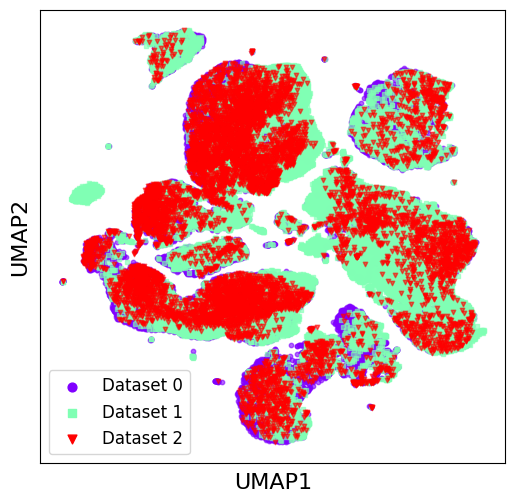

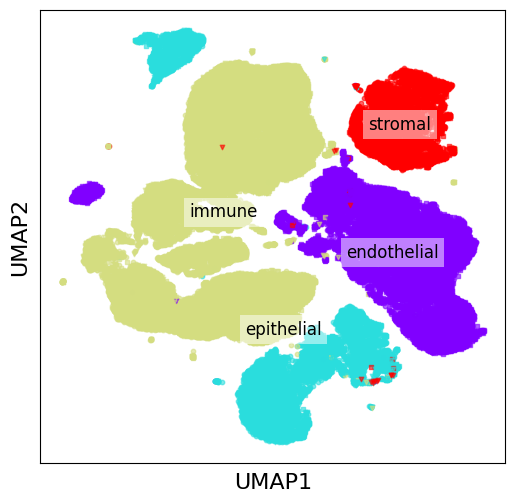

In [12]:
from transmorph.utils import plotting as tpl
from transmorph import settings

settings.neighbors_n_pcs = 5

tpl.reduce_dimension(
    datasets,
    reducer="umap", 
    input_obsm="transmorph",
    output_obsm="after_transmorph"
)

tpl.scatter_plot( # Per batch
    datasets, 
    input_obsm="after_transmorph"
)
tpl.scatter_plot( # Per type
    datasets,
    input_obsm="after_transmorph",
    color_by="class",
    show_legend=False, 
    plot_cluster_names=True
)

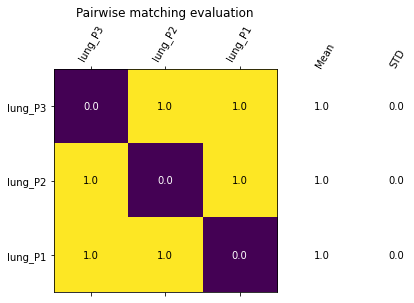

In [13]:
from transmorph.utils.plotting import plot_matching_eval
from transmorph.engine.evaluators import matching_edge_accuracy_discrete
from transmorph.engine.layers import LayerMatching

lmatch = model.get_layers_by_type(LayerMatching)[0]
plot_matching_eval(lmatch, datasets, matching_edge_accuracy_discrete("class"), trav_10x.keys())

In [15]:
import numpy as np

from transmorph.utils.anndata_manager import slice_common_features

X_before = np.concatenate(slice_common_features(datasets), axis=0)
X_after = np.concatenate([adata.obsm['X_transmorph'] for adata in datasets], axis=0)

X_before.shape, X_after.shape

((65662, 6335), (65662, 6335))

In [27]:
from transmorph.stats.lisi import compute_lisi

lb_datasets = np.array(sum([[i]*adata.n_obs for i, adata in enumerate(datasets)], []))
lb_types_str = np.concatenate([adata.obs["class"] for adata in datasets])
lb_types_int = np.zeros(lb_types_str.shape, dtype=int)

all_types = set(lb_types_str)
for i, type_ in enumerate(all_types):
    lb_types_int[lb_types_str == type_] = i

In [36]:
lisi_batch_b = compute_lisi(X_before, lb_datasets)
lisi_batch_a = compute_lisi(X_after, lb_datasets)
lisi_types_b = compute_lisi(X_before, lb_types_int)
lisi_types_a = compute_lisi(X_after, lb_types_int)

print("LISI batch bef:", lisi_batch_b.mean())
print("LISI batch aft:", lisi_batch_a.mean())
print("LISI types bef:", lisi_types_b.mean())
print("LISI types aft:", lisi_types_a.mean())

LISI batch bef: 1.8002936
LISI batch aft: 1.8390151
LISI types bef: 1.0018848
LISI types aft: 1.0013378


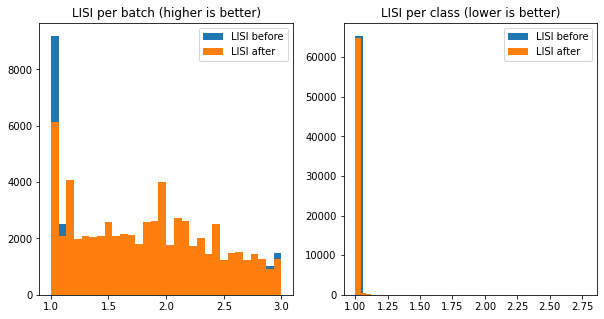

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.hist(lisi_batch_b, label="LISI before", bins=30)
plt.hist(lisi_batch_a, label="LISI after", bins=30)
plt.title("LISI per batch (higher is better)")
plt.legend()

plt.subplot(1,2,2)
plt.hist(lisi_types_b, label="LISI before", bins=30)
plt.hist(lisi_types_a, label="LISI after", bins=30)
plt.title("LISI per class (lower is better)")
plt.legend()